In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [2]:
filename = 'housing.csv'

In [3]:
df = pd.read_csv(filename)

# Exploration

In [4]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


9 numeric features; 1 categorical feature; some total_bedrooms missing

In [6]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


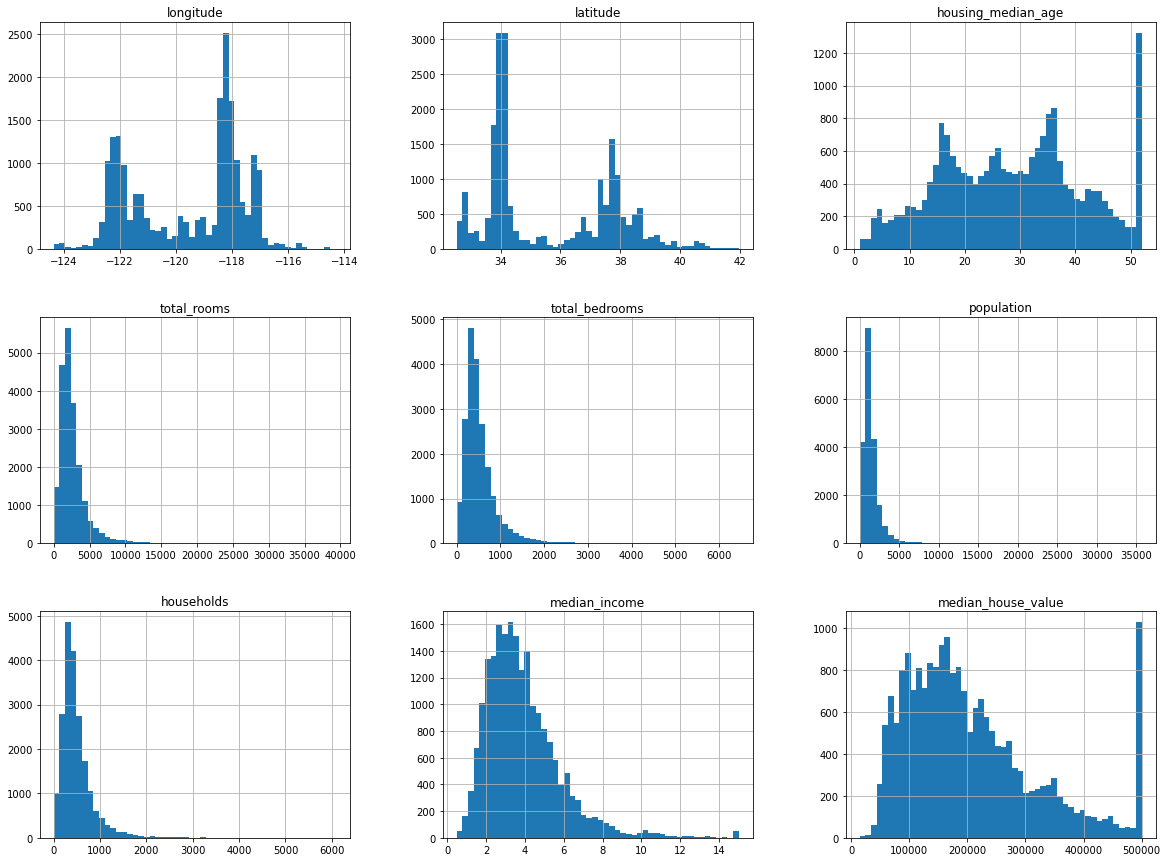

In [8]:
df.hist(bins=50, figsize=(20,15))
plt.show()

median_house_value, median_house_age & median_income are aggregated at some point (need to be removed in training-data) - 
especially problematic with the target (wrong values)

median_income is scaled: 1 == 10_000 USD

# Split the data

In [9]:
def split_dataset(data):

    df = data.copy()
    
    y = df['median_house_value']
    X = df.drop('median_house_value', axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = split_dataset(df)

# Feature Engineering

In [11]:
#use copies
features = X_train.copy()
labels = y_train.copy()

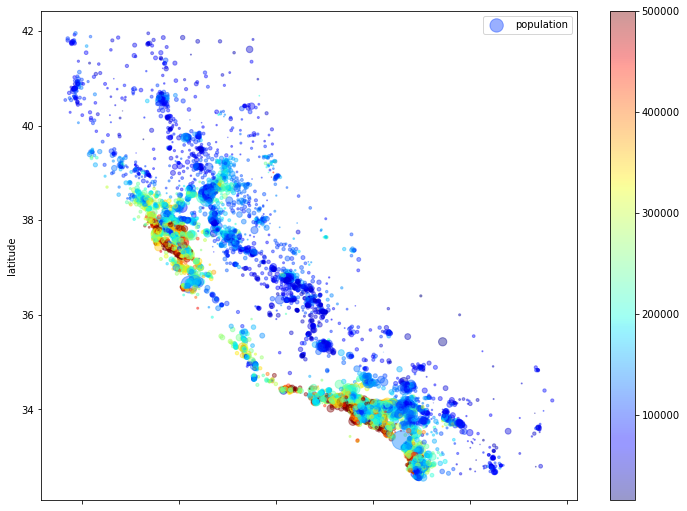

In [12]:
features.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=features['population']/100,
             label='population', figsize=(12,9), cmap=plt.get_cmap('jet'), colorbar=True, c=labels)
plt.legend()

In [13]:
features.corrwith(labels).sort_values(ascending=False)

median_income         0.690647
total_rooms           0.133989
housing_median_age    0.103706
households            0.063714
total_bedrooms        0.047980
population           -0.026032
longitude            -0.046349
latitude             -0.142983
dtype: float64

median_income by far the highest correlation with target as expected -> see if a stratified sample is necessary 

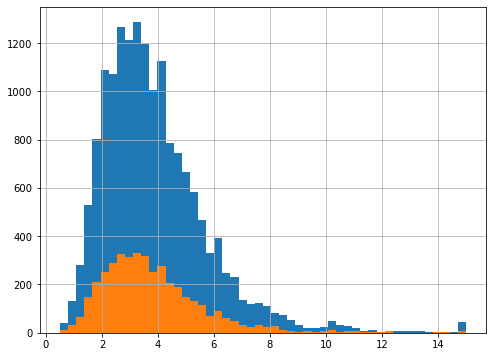

In [14]:
X_train['median_income'].hist(bins=50, figsize=(8,6))
X_test['median_income'].hist(bins=50, figsize=(8,6))
plt.show()

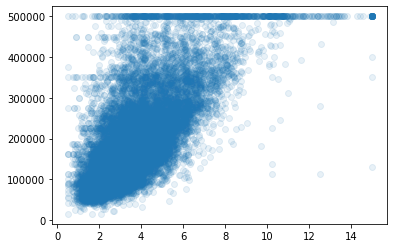

In [15]:
plt.scatter(features['median_income'], labels, alpha=0.1)

Aggregated values are gonna worsen the model for real values -> remove (based on frequency)

In [16]:
most = labels.value_counts()
most.iloc[0:15]

500001.0    786
137500.0     93
162500.0     89
112500.0     82
187500.0     73
225000.0     69
350000.0     66
87500.0      61
100000.0     53
275000.0     53
150000.0     48
175000.0     48
125000.0     46
250000.0     41
67500.0      39
Name: median_house_value, dtype: int64

In [17]:
#Remove all values that appear more than 60 times
to_remove = []  # list with median_income values to be removed
#most is in a descending order, so when the first value (frequency) below 60 is reached no more will come
for number in range(len(most)):
    if most.iloc[number] > 60:
        to_remove.append(most.index[number])
    else:
        break
print(to_remove)

[500001.0, 137500.0, 162500.0, 112500.0, 187500.0, 225000.0, 350000.0, 87500.0]


In [18]:
len(features)

16512

Filter the values out based on their indeces

In [19]:
indices_to_remove = labels[labels.isin(to_remove)].index

In [20]:
features.drop(indices_to_remove, axis=0, inplace=True)
labels.drop(indices_to_remove, axis=0, inplace=True)

In [21]:
len(features)

15193

That works so now write a fuction and filter the real training data

In [22]:
def remove_dublicates_abouve_60(X, y):
    most = y.value_counts()  # descenting order
    to_remove = []
    for number in range(len(most)):
        if most.iloc[number] > 60:
            to_remove.append(most.index[number])
        else:  # if not, stop (descending)
            break

    indices_to_remove = y[y.isin(to_remove)].index
    
    X.drop(indices_to_remove, axis=0, inplace=True)
    y.drop(indices_to_remove, axis=0, inplace=True)
    
    return X, y

In [23]:
X_train, y_train = remove_dublicates_abouve_60(X=X_train, y=y_train)

Combine some features to get more meaningful ones & reduce the dimensionality

In [24]:
#household per population & bedrooms per room
features['households_per_population'] = features['households'] / features['population']
features['bedrooms_per_room'] = features['total_bedrooms'] / features['total_rooms']

In [25]:
features.head(1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,households_per_population,bedrooms_per_room
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,NEAR OCEAN,0.27087,0.200576


In [26]:
features.corrwith(labels).sort_values(ascending=False)

median_income                0.654255
households_per_population    0.245017
total_rooms                  0.144140
households                   0.094031
total_bedrooms               0.074207
housing_median_age           0.059325
population                   0.009114
longitude                   -0.043531
latitude                    -0.152367
bedrooms_per_room           -0.238353
dtype: float64

Significantly higher correlation -> use combinded attributes and remove the features

In [29]:
def preprocess(X):
    
    X['households_per_population'] = X['households'] / X['population']
    X['bedrooms_per_room'] = X['total_bedrooms'] / X['total_rooms']
    
    X.drop(['households', 'population', 'total_bedrooms', 'total_rooms'], axis=1, inplace=True)
    
    return X

In [30]:
X_train = preprocess(X_train)

In [31]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'median_income',
       'ocean_proximity', 'households_per_population', 'bedrooms_per_room'],
      dtype='object')

# Build a preprocessing pipeline

In [33]:
num_attribs = ['longitude', 'latitude', 'housing_median_age', 'median_income',
               'households_per_population', 'bedrooms_per_room']
cat_attribs = ['ocean_proximity']

In [34]:
num_pipeline = Pipeline([
    ('Imputer_num', SimpleImputer(strategy='median')),  # fill total_bedrooms
    ('Standardize_num', StandardScaler())
])

In [35]:
cat_pipeline = Pipeline([
    ('Imputer_cat', SimpleImputer(strategy='most_frequent')),  # for missing features in the future
    ('OneHotEncoding_cat', OneHotEncoder(sparse=False))  # return array not sparse matrix
])

In [36]:
preprocess_pipeline = ColumnTransformer([
    ('Num_pipeline', num_pipeline, num_attribs),
    ('Cat_pipeline', cat_pipeline, cat_attribs)
])

In [37]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'median_income',
       'ocean_proximity', 'households_per_population', 'bedrooms_per_room'],
      dtype='object')

In [38]:
X_train = preprocess_pipeline.fit_transform(X_train)

In [39]:
X_train[0]

array([ 1.26477069, -1.37085496,  0.37681458, -0.29069582, -1.00351422,
       -0.22591125,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ])

In [40]:
X_train.shape

(15193, 11)

In [41]:
y_train = np.array(y_train)

In [42]:
y_train

array([103000., 382100., 172600., ..., 222100., 283500., 325000.])

# Trying different models and tune hyperparameters

1) Linear Regression

In [43]:
lin_reg = LinearRegression()

In [44]:
lin_reg.fit(X_train, y_train)

LinearRegression()

In [45]:
lin_reg_pred = lin_reg.predict(X_train)

In [46]:
lin_mse = mean_squared_error(y_train, lin_reg_pred)

In [47]:
lin_rmse = np.sqrt(lin_mse)

In [48]:
lin_rmse

57598.98929551262

2) Support Vector Regression

In [49]:
svr = SVR()

In [50]:
svr_params = [
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     'degree': [1, 2, 3, 4],
     'C': [1.0, 10, 100, 1_000]}
]

In [51]:
svr_search = RandomizedSearchCV(svr, svr_params, cv=5, scoring='neg_mean_squared_error')

In [53]:
svr_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START C=1.0, degree=1, epsilon=0, kernel=poly....................
[CV 1/5; 1/10] END C=1.0, degree=1, epsilon=0, kernel=poly;, score=(train=-9814582899.437, test=-9883473800.174) total time=   3.7s
[CV 2/5; 1/10] START C=1.0, degree=1, epsilon=0, kernel=poly....................
[CV 2/5; 1/10] END C=1.0, degree=1, epsilon=0, kernel=poly;, score=(train=-9860347610.225, test=-9681857531.779) total time=   3.6s
[CV 3/5; 1/10] START C=1.0, degree=1, epsilon=0, kernel=poly....................
[CV 3/5; 1/10] END C=1.0, degree=1, epsilon=0, kernel=poly;, score=(train=-9839725140.278, test=-9633352029.921) total time=   3.6s
[CV 4/5; 1/10] START C=1.0, degree=1, epsilon=0, kernel=poly....................
[CV 4/5; 1/10] END C=1.0, degree=1, epsilon=0, kernel=poly;, score=(train=-9758142376.616, test=-9916555760.698) total time=   3.6s
[CV 5/5; 1/10] START C=1.0, degree=1, epsilon=0, kernel=poly....................
[CV 5/

[CV 4/5; 8/10] END C=100, degree=3, epsilon=0, kernel=sigmoid;, score=(train=-4619479778.274, test=-4722925082.408) total time=   7.0s
[CV 5/5; 8/10] START C=100, degree=3, epsilon=0, kernel=sigmoid.................
[CV 5/5; 8/10] END C=100, degree=3, epsilon=0, kernel=sigmoid;, score=(train=-4595340162.581, test=-4802011275.656) total time=   7.0s
[CV 1/5; 9/10] START C=100, degree=1, epsilon=0, kernel=linear..................
[CV 1/5; 9/10] END C=100, degree=1, epsilon=0, kernel=linear;, score=(train=-3532728185.082, test=-3543231038.639) total time=   3.4s
[CV 2/5; 9/10] START C=100, degree=1, epsilon=0, kernel=linear..................
[CV 2/5; 9/10] END C=100, degree=1, epsilon=0, kernel=linear;, score=(train=-3555843381.394, test=-3453385768.312) total time=   3.3s
[CV 3/5; 9/10] START C=100, degree=1, epsilon=0, kernel=linear..................
[CV 3/5; 9/10] END C=100, degree=1, epsilon=0, kernel=linear;, score=(train=-3574826902.930, test=-3339927247.799) total time=   3.3s
[CV 

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions=[{'C': [1.0, 10, 100, 1000],
                                         'degree': [1, 2, 3, 4],
                                         'epsilon': [0, 0.1],
                                         'kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']}],
                   return_train_score=True, scoring='neg_mean_squared_error',
                   verbose=10)

In [54]:
svr_search.best_params_

{'kernel': 'rbf', 'epsilon': 0.1, 'degree': 3, 'C': 1000}

In [55]:
svr_search.best_score_

-3323823499.0790243

In [56]:
svr_rmse = np.sqrt(-svr_search.best_score_)

In [57]:
svr_rmse

57652.61051400036

In [59]:
svr_params_2 = [
    {'kernel': ['rbf'],
     'degree': [3],
     'C': [300, 500, 700, 850, 1_000, 1_250, 1_500, 2_000, 3_000, 5_000]}
]

In [60]:
svr_2 = SVR()

In [62]:
svr_search_2 = RandomizedSearchCV(svr_2, svr_params_2, cv=5, scoring='neg_mean_squared_error')

In [63]:
svr_search_2.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVR(),
                   param_distributions=[{'C': [300, 500, 700, 850, 1000, 1250,
                                               1500, 2000, 3000, 5000],
                                         'degree': [3], 'kernel': ['rbf']}],
                   return_train_score=True, scoring='neg_mean_squared_error')

In [64]:
svr_search_2.best_params_

{'kernel': 'rbf', 'degree': 3, 'C': 5000}

In [65]:
svr_2_rmse = np.sqrt(-svr_search_2.best_score_)

In [66]:
svr_2_rmse

52643.22123031386

In [69]:
svr_params_3 = [
    {'kernel': ['rbf'],
     'degree': [3],
     'C': [4_000, 5_000, 10_000, 20_000, 100_000]}
]

In [68]:
svr_3 = SVR()

In [70]:
svr_search_3 = GridSearchCV(svr_3, svr_params_3, cv=5, scoring='neg_mean_squared_error')

In [71]:
svr_search_3.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [4000, 5000, 10000, 20000, 100000],
                          'degree': [3], 'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [72]:
svr_search_3.best_params_

{'C': 100000, 'degree': 3, 'kernel': 'rbf'}

In [73]:
svr_3_rmse = np.sqrt(-svr_search_3.best_score_)

In [74]:
svr_3_rmse

48841.960733809436

In [79]:
svr_params_4 = [
    {'kernel': ['rbf'],
     'degree': [3],
     'C': [50_000, 75_000, 100_000, 150_000]}
]

In [80]:
svr_4 = SVR()

In [81]:
svr_search_4 = GridSearchCV(svr_4, svr_params_4, cv=5, scoring='neg_mean_squared_error')

In [82]:
svr_search_4.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [50000, 75000, 100000, 150000], 'degree': [3],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [83]:
svr_search_4.best_params_

{'C': 150000, 'degree': 3, 'kernel': 'rbf'}

In [84]:
svr_4_rmse = np.sqrt(-svr_search_4.best_score_)

In [85]:
svr_4_rmse

48462.94780358047

In [103]:
svr_best = SVR(kernel='rbf', degree=3, C=150_000)

In [104]:
svr_best.fit(X_train, y_train)

SVR(C=150000)

In [115]:
joblib.dump(svr_best, 'SVR_best_model.joblib')

['SVR_best_model.joblib']

3) Dicision Tree Regressor

In [86]:
dtr = DecisionTreeRegressor()

In [87]:
dtr_params = [
    {"splitter":["best","random"],
     "max_depth" : [None, 1, 3, 5, 7, 9, 11, 12],
     "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
     "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.499],
     "max_features":["auto","log2","sqrt",None],
     "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}
]

In [88]:
dtr_search = RandomizedSearchCV(dtr, dtr_params, cv=5, scoring='neg_mean_squared_error', n_iter=35)

In [90]:
dtr_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=35,
                   param_distributions=[{'max_depth': [None, 1, 3, 5, 7, 9, 11,
                                                       12],
                                         'max_features': ['auto', 'log2',
                                                          'sqrt', None],
                                         'max_leaf_nodes': [None, 10, 20, 30,
                                                            40, 50, 60, 70, 80,
                                                            90],
                                         'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                              7, 8, 9, 10],
                                         'min_weight_fraction_leaf': [0.1, 0.2,
                                                                      0.3, 0.4,
                                                                      0.499],
                         

In [91]:
dtr_search.best_params_

{'splitter': 'best',
 'min_weight_fraction_leaf': 0.1,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 30,
 'max_features': None,
 'max_depth': None}

In [92]:
dtr_best_rmse = np.sqrt(-dtr_search.best_score_)

In [94]:
dtr_best_rmse

66495.24486119684

4) Random Forest Regressor

In [95]:
rfr = RandomForestRegressor()

In [96]:
rfr_params = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

In [97]:
rfr_search = RandomizedSearchCV(rfr, rfr_params, cv=5, scoring='neg_mean_squared_error', n_iter=30)

In [99]:
rfr_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=30,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='neg_mean_squared_error')

In [100]:
rfr_search.best_params_

{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [101]:
rfr_best_rmse = np.sqrt(-rfr_search.best_score_)

In [102]:
rfr_best_rmse

42331.9571944459

In [108]:
rfr_params_2 = {
    'n_estimators': list(range(1600, 2000, 10)),
    'min_samples_split': [1.0, 2, 3],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'max_depth': [25, 30, 35],
    'bootstrap': [False]
}

In [117]:
rfr_search_2 = RandomizedSearchCV(RandomForestRegressor(), rfr_params_2, cv=5, n_iter=20,
                                  scoring='neg_mean_squared_error')

In [118]:
rfr_search_2.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [25, 30, 35],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [1.0, 2, 3],
                                        'n_estimators': [1600, 1610, 1620, 1630,
                                                         1640, 1650, 1660, 1670,
                                                         1680, 1690, 1700, 1710,
                                                         1720, 1730, 1740, 1750,
                                                         1760, 1770, 1780, 1790,
                                                         1800, 1810, 1820, 1830,
                                                         1840, 1850, 1860, 1870,
                            

In [119]:
rfr_search_2.best_params_

{'n_estimators': 1840,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [120]:
rfr_search_2.best_score_

-1786293811.9867072

In [121]:
rfr_2_rmse = np.sqrt(-rfr_search_2.best_score_)

In [122]:
rfr_2_rmse

42264.56922750671

In [123]:
rfr_best = RandomForestRegressor(
    n_estimators=1850,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    max_depth=30,
    bootstrap=False
)

In [124]:
rfr_best.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=30, max_features='sqrt',
                      n_estimators=1850)

In [125]:
joblib.dump(rfr_best, 'RFR_best_model.joblib')

['RFR_best_model.joblib']

5) Gradient Boosting Regressor

In [126]:
gbr = GradientBoostingRegressor()

In [127]:
gbr_params = {
    'n_estimators': [200, 600, 1000, 1400, 1800, 2500],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 50, 90, 150]
}

In [128]:
gbr_search = RandomizedSearchCV(gbr, gbr_params, cv=3, scoring='neg_mean_squared_error')

In [130]:
gbr_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(),
                   param_distributions={'max_depth': [10, 50, 90, 150],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 600, 1000, 1400,
                                                         1800, 2500]},
                   scoring='neg_mean_squared_error')

In [131]:
gbr_search.best_params_

{'n_estimators': 2500,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10}

In [140]:
gbr_rmse = np.sqrt(-gbr_search.best_score_)
gbr_rmse

41428.32813466673

In [132]:
gbr_2 = GradientBoostingRegressor()

In [133]:
gbr_params_2 = {
    'n_estimators': [2_500, 5_000, 50_000],
    'min_samples_split': [5],
    'min_samples_leaf': [4],
    'max_features': ['sqrt'],
    'max_depth': [5, 10, 20]
}

In [136]:
gbr_search_2 = GridSearchCV(gbr_2, gbr_params_2, cv=3, scoring='neg_mean_squared_error')

In [137]:
gbr_search_2.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [5, 10, 20], 'max_features': ['sqrt'],
                         'min_samples_leaf': [4], 'min_samples_split': [5],
                         'n_estimators': [2500, 5000, 50000]},
             scoring='neg_mean_squared_error')

In [138]:
gbr_search_2.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 5000}

In [141]:
gbr_2_rmse = np.sqrt(-gbr_search_2.best_score_)
gbr_2_rmse

41254.44089285433

In [142]:
gbr_best = GradientBoostingRegressor(
    n_estimators = 5_000,
    min_samples_split = 5,
    min_samples_leaf = 4,
    max_features = 'sqrt',
    max_depth = 5
)

In [143]:
gbr_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', min_samples_leaf=4,
                          min_samples_split=5, n_estimators=5000)

In [144]:
joblib.dump(gbr_best, 'GBR_best_model.joblib')

['GBR_best_model.joblib']

6) Neural Network

In [146]:
def build_model(hp):
    model = keras.models.Sequential()
    model.add(Input(shape=X_train.shape[1:]))
        
    num_layers = hp.Int('Numver_of_Layers', 2, 5, 1)
    drop_rate = hp.Float('Dropout_Rate', 0.1, 0.5, 0.1)
        
    for layer in range(num_layers):
        model.add(Dense(units=hp.Int(f'{layer}_Layer_Dense_Units', 32, 256, 32)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=drop_rate))
    
    model.add(Dense(1, activation='relu'))  # negative prices make no sense
    
    LEARNING_RATE = hp.Float('Learning_Rate', 1e-5, 1e-2, sampling='log')
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError()])
        
    return model

In [147]:
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_loss',
    max_trials=250,
    directory='Real_Estate_Logs_1')

2022-03-31 15:59:58.261928: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 15:59:58.283439: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 15:59:58.284257: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-31 15:59:58.285986: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [153]:
%%time
tuner.search(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

Trial 251 Complete [00h 00m 07s]
val_loss: 47133802496.0

Best val_loss So Far: 2853152768.0
Total elapsed time: 00h 45m 56s
INFO:tensorflow:Oracle triggered exit
CPU times: user 58min 53s, sys: 3min 40s, total: 1h 2min 33s
Wall time: 44min 45s


In [155]:
tuner.results_summary(5)

Results summary
Results in Real_Estate_Logs_1/untitled_project
Showing 5 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Numver_of_Layers: 2
Dropout_Rate: 0.1
0_Layer_Dense_Units: 192
1_Layer_Dense_Units: 192
Learning_Rate: 0.009411806710468915
2_Layer_Dense_Units: 96
3_Layer_Dense_Units: 128
4_Layer_Dense_Units: 64
Score: 2853152768.0
Trial summary
Hyperparameters:
Numver_of_Layers: 5
Dropout_Rate: 0.1
0_Layer_Dense_Units: 128
1_Layer_Dense_Units: 64
Learning_Rate: 0.007688762092679064
2_Layer_Dense_Units: 256
3_Layer_Dense_Units: 160
4_Layer_Dense_Units: 224
Score: 2999481088.0
Trial summary
Hyperparameters:
Numver_of_Layers: 3
Dropout_Rate: 0.5
0_Layer_Dense_Units: 160
1_Layer_Dense_Units: 96
Learning_Rate: 0.009761373399855767
2_Layer_Dense_Units: 160
3_Layer_Dense_Units: 192
4_Layer_Dense_Units: 160
Score: 3153096960.0
Trial summary
Hyperparameters:
Numver_of_Layers: 4
Dropout_Rate: 0.4
0_Layer_Dense_Units: 256
1_Layer_Dense_Units: 128
Learni

In [161]:
def build_model_2(hp):
    model = keras.models.Sequential()
    
    drop_rate = hp.Float('Dropout_Rate', 0.1, 0.5, 0.1)
    
    model.add(Input(shape=X_train.shape[1:]))
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=drop_rate))
    
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(rate=drop_rate))
    
    if hp.Boolean('3_Layer'):
        model.add(Dense(units=hp.Int('3_Dense_Units', 32, 128, 32)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=drop_rate))
    
    if hp.Boolean('4_Layer'):    
        model.add(Dense(units=hp.Int('4_Dense_Units', 8, 64, 8)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(rate=drop_rate))
        
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(learning_rate=0.009),
                  loss=MeanSquaredError(),
                  metrics=[RootMeanSquaredError()])
    
    return model

In [162]:
tuner_2 = kt.RandomSearch(
    hypermodel=build_model_2,
    objective='val_loss',
    max_trials=100,
    directory='Real_Estate_Logs_2')

In [163]:
tuner_2.search(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[EarlyStopping(patience=3)])

Trial 100 Complete [00h 00m 15s]
val_loss: 2826139392.0

Best val_loss So Far: 2494342656.0
Total elapsed time: 00h 31m 09s
INFO:tensorflow:Oracle triggered exit


In [164]:
tuner_2.results_summary(5)

Results summary
Results in Real_Estate_Logs_2/untitled_project
Showing 5 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
Dropout_Rate: 0.1
3_Layer: True
4_Layer: False
4_Dense_Units: 48
3_Dense_Units: 96
Score: 2494342656.0
Trial summary
Hyperparameters:
Dropout_Rate: 0.2
3_Layer: True
4_Layer: False
4_Dense_Units: 56
3_Dense_Units: 64
Score: 2547969536.0
Trial summary
Hyperparameters:
Dropout_Rate: 0.2
3_Layer: False
4_Layer: True
4_Dense_Units: 64
3_Dense_Units: 32
Score: 2566008064.0
Trial summary
Hyperparameters:
Dropout_Rate: 0.1
3_Layer: False
4_Layer: False
Score: 2581800704.0
Trial summary
Hyperparameters:
Dropout_Rate: 0.2
3_Layer: False
4_Layer: True
4_Dense_Units: 56
3_Dense_Units: 128
Score: 2583572224.0


In [165]:
nn_best_params = tuner_2.get_best_hyperparameters()[0]

In [166]:
nn = tuner_2.hypermodel.build(nn_best_params)

In [167]:
tb = keras.callbacks.TensorBoard()
es = keras.callbacks.EarlyStopping(patience=20)
mc = keras.callbacks.ModelCheckpoint(filepath='nn_best.h5', save_best_only=True)
cb = [tb, es, mc]

In [168]:
nn.fit(X_train, y_train, epochs=200, batch_size=32, callbacks=cb, validation_split=0.2)

Epoch 1/200
380/380 [==============================] - 1s 3ms/step - loss: 46410940416.0000 - root_mean_squared_error: 215431.9844 - val_loss: 45002276864.0000 - val_root_mean_squared_error: 212137.4062
Epoch 2/200
380/380 [==============================] - 1s 3ms/step - loss: 43357704192.0000 - root_mean_squared_error: 208225.1250 - val_loss: 40963862528.0000 - val_root_mean_squared_error: 202395.3125
Epoch 3/200
380/380 [==============================] - 1s 2ms/step - loss: 37923958784.0000 - root_mean_squared_error: 194740.7500 - val_loss: 33918703616.0000 - val_root_mean_squared_error: 184170.3125
Epoch 4/200
380/380 [==============================] - 1s 3ms/step - loss: 31267010560.0000 - root_mean_squared_error: 176824.7969 - val_loss: 28386582528.0000 - val_root_mean_squared_error: 168483.1875
Epoch 5/200
380/380 [==============================] - 1s 3ms/step - loss: 24371075072.0000 - root_mean_squared_error: 156112.3750 - val_loss: 21746536448.0000 - val_root_mean_squared_erro

Epoch 42/200
380/380 [==============================] - 1s 2ms/step - loss: 2652205824.0000 - root_mean_squared_error: 51499.5703 - val_loss: 2412898048.0000 - val_root_mean_squared_error: 49121.2578
Epoch 43/200
380/380 [==============================] - 1s 3ms/step - loss: 2659302912.0000 - root_mean_squared_error: 51568.4297 - val_loss: 2380142080.0000 - val_root_mean_squared_error: 48786.6992
Epoch 44/200
380/380 [==============================] - 1s 2ms/step - loss: 2644452608.0000 - root_mean_squared_error: 51424.2422 - val_loss: 2464777216.0000 - val_root_mean_squared_error: 49646.5234
Epoch 45/200
380/380 [==============================] - 1s 3ms/step - loss: 2614769664.0000 - root_mean_squared_error: 51134.8164 - val_loss: 2376600832.0000 - val_root_mean_squared_error: 48750.3945
Epoch 46/200
380/380 [==============================] - 1s 3ms/step - loss: 2638655744.0000 - root_mean_squared_error: 51367.8477 - val_loss: 2468266752.0000 - val_root_mean_squared_error: 49681.6523


380/380 [==============================] - 1s 2ms/step - loss: 2461032192.0000 - root_mean_squared_error: 49608.7891 - val_loss: 2257860864.0000 - val_root_mean_squared_error: 47516.9531
Epoch 83/200
380/380 [==============================] - 1s 2ms/step - loss: 2462507264.0000 - root_mean_squared_error: 49623.6562 - val_loss: 2275590400.0000 - val_root_mean_squared_error: 47703.1484
Epoch 84/200
380/380 [==============================] - 1s 2ms/step - loss: 2479996160.0000 - root_mean_squared_error: 49799.5625 - val_loss: 2288147456.0000 - val_root_mean_squared_error: 47834.5820
Epoch 85/200
380/380 [==============================] - 1s 2ms/step - loss: 2440694528.0000 - root_mean_squared_error: 49403.3867 - val_loss: 2300377600.0000 - val_root_mean_squared_error: 47962.2500
Epoch 86/200
380/380 [==============================] - 1s 2ms/step - loss: 2466789888.0000 - root_mean_squared_error: 49666.7891 - val_loss: 2230500096.0000 - val_root_mean_squared_error: 47228.1719
Epoch 87/200


Epoch 123/200
380/380 [==============================] - 1s 2ms/step - loss: 2404846080.0000 - root_mean_squared_error: 49039.2305 - val_loss: 2207234048.0000 - val_root_mean_squared_error: 46981.2109
Epoch 124/200
380/380 [==============================] - 1s 2ms/step - loss: 2391676160.0000 - root_mean_squared_error: 48904.7656 - val_loss: 2189156608.0000 - val_root_mean_squared_error: 46788.4219
Epoch 125/200
380/380 [==============================] - 1s 2ms/step - loss: 2436239872.0000 - root_mean_squared_error: 49358.2812 - val_loss: 2278617600.0000 - val_root_mean_squared_error: 47734.8672
Epoch 126/200
380/380 [==============================] - 1s 2ms/step - loss: 2362433024.0000 - root_mean_squared_error: 48604.8672 - val_loss: 2214464256.0000 - val_root_mean_squared_error: 47058.0938
Epoch 127/200
380/380 [==============================] - 1s 2ms/step - loss: 2388493568.0000 - root_mean_squared_error: 48872.2148 - val_loss: 2154225664.0000 - val_root_mean_squared_error: 46413.

In [169]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6008

# Evaluate each model with the testset

In [173]:
X_test = preprocess(X_test)

In [176]:
X_test = preprocess_pipeline.transform(X_test)

In [178]:
y_test = np.array(y_test)

In [179]:
def evaluate(model, X, y):
    prediction = model.predict(X)
    mse = mean_squared_error(y, prediction)
    rmse = np.sqrt(mse)
    print(rmse)

In [197]:
evaluate(svr_best, X_test, y_test)

57846.31747918609


In [198]:
evaluate(rfr_best, X_test, y_test)

49309.00024182606


In [199]:
evaluate(gbr_best, X_test, y_test)

45460.93453116578


In [200]:
nn_best = tf.keras.models.load_model('nn_best.h5')

In [201]:
evaluate(nn_best, X_test, y_test)

55522.6308297926


All models perform slightly worse on the testset but svr & nn worse compared to rfr & gbr

In [206]:
rfr_gbr = VotingRegressor(
    estimators=[('rfr', rfr_best), ('gbr', gbr_best)]
)

In [207]:
rfr_gbr.fit(X_train, y_train)

VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(bootstrap=False,
                                                   max_depth=30,
                                                   max_features='sqrt',
                                                   n_estimators=1850)),
                            ('gbr',
                             GradientBoostingRegressor(max_depth=5,
                                                       max_features='sqrt',
                                                       min_samples_leaf=4,
                                                       min_samples_split=5,
                                                       n_estimators=5000))])

In [208]:
evaluate(rfr_gbr, X_test, y_test)

45824.5597424881


In [211]:
rfr_gbr_weighted = VotingRegressor(
    estimators=[('rfr', rfr_best), ('gbr', gbr_best)],
    weights=[0.35, 0.65]
)

In [212]:
rfr_gbr_weighted.fit(X_train, y_train)

VotingRegressor(estimators=[('rfr',
                             RandomForestRegressor(bootstrap=False,
                                                   max_depth=30,
                                                   max_features='sqrt',
                                                   n_estimators=1850)),
                            ('gbr',
                             GradientBoostingRegressor(max_depth=5,
                                                       max_features='sqrt',
                                                       min_samples_leaf=4,
                                                       min_samples_split=5,
                                                       n_estimators=5000))],
                weights=[0.35, 0.65])

In [213]:
evaluate(rfr_gbr_weighted, X_test, y_test)

45491.6844974767


GBR perfroms best

# Use all data and build a full pipeline

In [221]:
X = df.copy()

In [222]:
y = X.pop('median_house_value')

In [223]:
X, y = remove_dublicates_abouve_60(X, y)

In [224]:
X = preprocess(X)

In [226]:
y = np.array(y)

In [227]:
final_model = Pipeline([
    ('preprocess_features', preprocess_pipeline),
    ('model', gbr_best)
])

In [228]:
final_model.fit(X, y)

Pipeline(steps=[('preprocess_features',
                 ColumnTransformer(transformers=[('Num_pipeline',
                                                  Pipeline(steps=[('Imputer_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('Standardize_num',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'median_income',
                                                   'households_per_population',
                                                   'bedrooms_per_room']),
                                                 ('Cat_pipeline',
                                                  Pipeline(steps=[('Imputer_cat',
                 

In [229]:
joblib.dump(final_model, 'final_model.joblib')

['final_model.joblib']